In [1]:
#track test
import sys, os
parent_path = os.path.normpath(os.path.abspath(os.path.join(os.getcwd(), os.path.pardir)))
#print(path2add)
sys.path.append(parent_path)
sys.path.append(os.path.normpath(os.path.join(parent_path,"gyrii")))
sys.path.append(os.path.normpath(os.path.join(parent_path,"gyrii","underpinnings")))
from notebook_log_loading import load_sensor_log_file
from id_to_name import id_to_name
sensor_log,first_timestamp=load_sensor_log_file("../to_study/sensor_log_chase_2.txt")

In [2]:
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

from gyrii.TrackerGyrusNoCV import MotionCorrection



# Input vector [track_x,track_z,left_motor_on,right_motor_on]
# Control vector [left_motor,right_motor,duration]
# Output vector [track_x,track_z]

# goal:  move track_x close to 0, track_z close to target number 


motor packet is 113.99790458679604 ms ahead
motor packet is 80.67590458679774 ms ahead
motor packet is 158.08951988219633 ms ahead
motor packet is 124.76151988219897 ms ahead
motor packet is 91.42751988220255 ms ahead
motor packet is 58.08051988219631 ms ahead
motor packet is 162.30837667846743 ms ahead
motor packet is 128.98237667846502 ms ahead
motor packet is 175.1296405334415 ms ahead
motor packet is 141.80164053344413 ms ahead
motor packet is 108.47364053344677 ms ahead
motor packet is 75.14364053344025 ms ahead
motor packet is 180.48745004271893 ms ahead
motor packet is 147.18145004272287 ms ahead
motor packet is 113.85245004272804 ms ahead
motor packet is 47.194450042724156 ms ahead
motor packet is 13.865450042729321 ms ahead
motor packet is 193.96981838988836 ms ahead
motor packet is 160.6238183898938 ms ahead
motor packet is 127.31181838989869 ms ahead
motor packet is 220.43702595520642 ms ahead
motor packet is 187.10802595519738 ms ahead
motor packet is 120.45102595520518 ms 

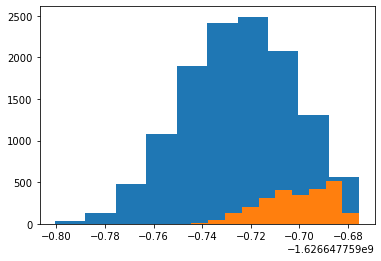

-1626647759.6754072


In [3]:
import numpy as np
from collections import deque
motioncorrection=MotionCorrection(max_recent_history=2000)

class TrackSegmenterRecord:
    def __init__(self,id):
        self.id=id
        self.timestamps=[]
        self.centers=[]
        self.velocities=[]
        self.missed_frames=[]
        self.l_motor=[]
        self.r_motor=[]
        
    def process_track(self,track,timestamp,lmotor,rmotor):
        self.timestamps.append(timestamp)
        self.centers.append(track["center"])
        self.velocities.append(track["velocity"])
        self.missed_frames.append(track["missed_frames"])                
        self.l_motor.append(lmotor)
        self.r_motor.append(rmotor)
        
    def finalize(self):
        self.centers=np.array(self.centers)
        self.velocities=np.array(self.velocities) 
        self.l_motor=np.array(self.l_motor)
        self.r_motor=np.array(self.r_motor)
        
    def generate_training_data(self):
        max_missed_frames=10
        input_vectors=[]
        control_vectors=[]
        output_vectors=[]
        for i in range(len(self.timestamps)-1):
            input_vector=[self.centers[i,0]]
            control_vector=[self.l_motor[i],self.r_motor[i]]
            output_vector=[self.centers[i+1][0]]
            input_vectors.append(input_vector)
            control_vectors.append(control_vector)
            output_vectors.append(output_vector)
            if self.missed_frames[i]>max_missed_frames:
                break
        return input_vectors,control_vectors,output_vectors
            
            
        
class TrackSegmenter:
    def __init__(self):
        #input:  [track x, track z, motor_on_l,motor_on_r] 
        self.left_motor_on=[]
        self.right_motor_on=[]
        self.motor_timestamp=[]
        self.motor_image_timestamp=[]
        self.time_ref=None
        self.ref_times=[]
        self.ref_times_last=[]
        self.track_records={}
        
        self.max_recent_history=20
        self.motors=deque([],maxlen=self.max_recent_history) # image_timestamp, left, right
        self.motors.append([0,0,0])
        
        self.last_motor_packet_image_timestamp=0
        self.last_gyro_packet_image=0
        self.last_frame_image=0
        
    def get_closest_motor_time(self,image_timestamp):
        #get the closest without going over
        prev_m=self.motors[0]
        for m in self.motors:
            if m[0]>image_timestamp:
                return prev_m
            prev_m=m
        return prev_m
        

        
    def read_message(self,message):
        #sort out timestamps and such
        if "packets" in message:
            if self.time_ref==None:
                self.time_ref=-message['timestamp']+message['packets'][-1]['gyroscope_timestamp']
            self.time_ref=max(time_ref,-message['timestamp']+message['packets'][-1]['gyroscope_timestamp'])
            for p in message['packets']:
                self.ref_times.append(-message['timestamp']+p['gyroscope_timestamp'])
            self.ref_times_last.append(-message['timestamp']+message['packets'][-1]['gyroscope_timestamp'])
            self.last_gyro_packet_image_timestamp=message['packets'][-1]['gyroscope_timestamp']
        if self.time_ref==None:
            return #don't even bother if I have no guess about time alignment
                    

        if "motor_response" in message:            
            motor_response=message["motor_response"]            
            motor_image_timestamp=message["timestamp"]+self.time_ref
            self.last_motor_packet_image_timestamp=motor_image_timestamp
            left_motor=self.motors[-1][1]
            right_motor=self.motors[-1][2]
            if "left_throttle" in motor_response:
                left_motor=motor_response["left_throttle"]
            if "right_throttle" in motor_response:
                right_motor=motor_response["right_throttle"]
            self.motors.append([motor_image_timestamp,left_motor,right_motor])
            
        if "tracks" in message:      
            #this is a frame, everything is keyd to this
            #find the appropriate motor time            
            last_motor=self.get_closest_motor_time(message["image_timestamp"])
                        
            #print("tracks time stamp: {}".format(message["image_timestamp"]))
            #if self.last_motor_packet_image_timestamp>message["image_timestamp"]:
            #    print("motor packet is {} ms ahead".format(1000*(self.last_motor_packet_image_timestamp-message["image_timestamp"])))
            #else:
            #    print("motor packet is {} ms behind".format(1000*(self.last_motor_packet_image_timestamp-message["image_timestamp"])))
            #print("gyro packet is {} ms ahead".format(1000*(self.last_gyro_packet_image_timestamp-message["image_timestamp"])))
                
            #print("last motor packet time: {}".format(self.last_motor_packet_image_timestamp))
            #print("last mgyro packet time: {}".format(self.last_gyro_packet_image_timestamp))
            for track in message["tracks"]:                
                if track["id"] not in self.track_records:
                    self.track_records[track["id"]]=TrackSegmenterRecord(track["id"])
                self.track_records[track["id"]].process_track(track,message["image_timestamp"],last_motor[1],last_motor[2])
                
    def purge_short(self,minlen):
        to_remove=[]
        for key in self.track_records:
            if len(self.track_records[key].timestamps)<minlen:
                to_remove.append(key)
        for key in to_remove:
            self.track_records.pop(key,None)
                
    def finalize(self):
        self.motor_timestamp=np.array(self.motor_timestamp)
        self.left_motor_on=np.array(self.left_motor_on)
        self.right_motor_on=np.array(self.right_motor_on)
        for key in self.track_records:
            self.track_records[key].finalize()          
            

    
            
time_ref=None
segmenter=TrackSegmenter()

for message in sensor_log:
    if "packets" in message:
        #print(message['timestamp'])
        #print(message['packets']['gyroscope_timestamp'][-1])
        if time_ref==None:
            time_ref=-message['timestamp']+message['packets'][-1]['gyroscope_timestamp']
        time_ref=max(time_ref,-message['timestamp']+message['packets'][-1]['gyroscope_timestamp'])
        #################
        #  itime
        #         ttime+x
        # timestamp=image_timestamp+x+y   where y can vary
        # x=image_timestamp-timestamp-y
    motioncorrection.read_message(message)
    segmenter.read_message(message)
    
segmenter.purge_short(27)
segmenter.finalize()
print(time_ref)

print("{} unique track ids".format(len(segmenter.track_records)))
    
fig, ax = plt.subplots()
plt.hist(segmenter.ref_times)
plt.hist(segmenter.ref_times_last)
plt.show()
print(segmenter.time_ref)


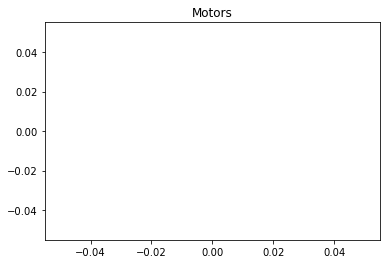

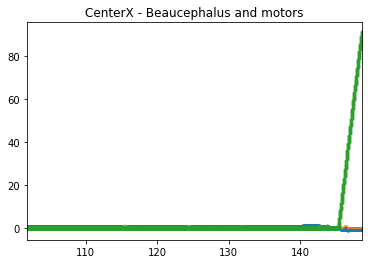

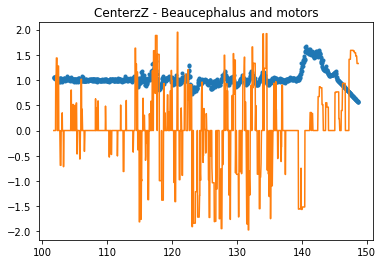

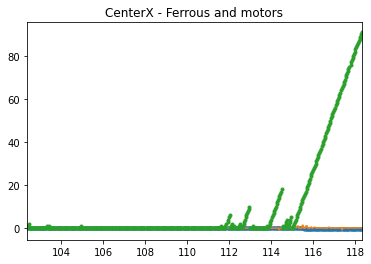

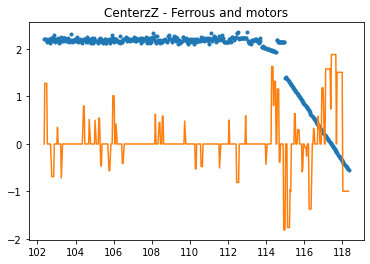

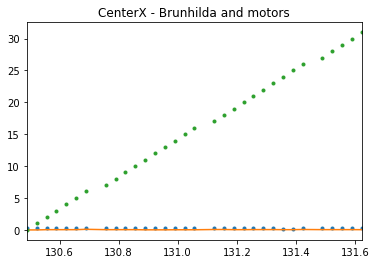

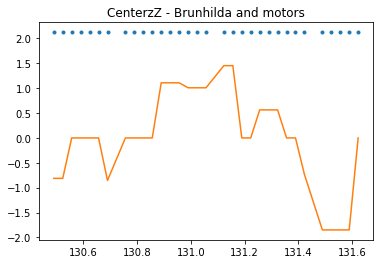

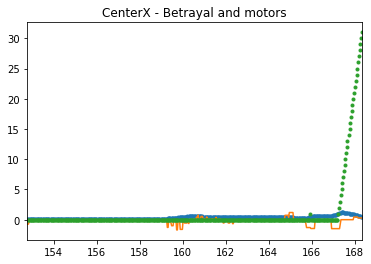

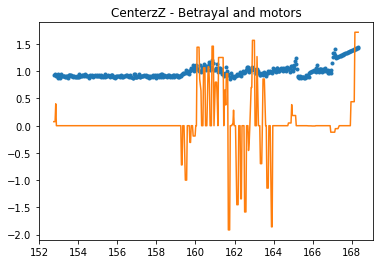

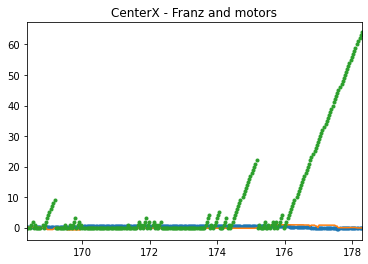

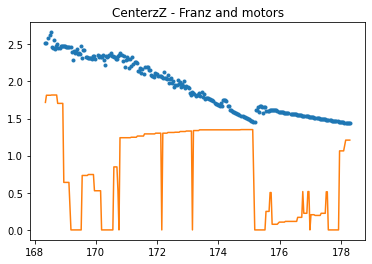

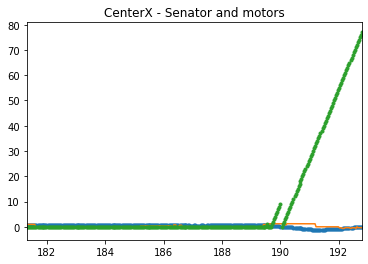

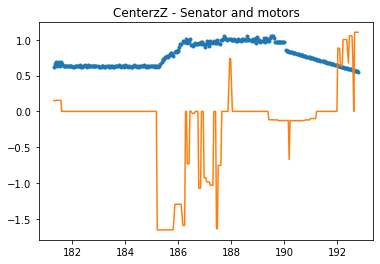

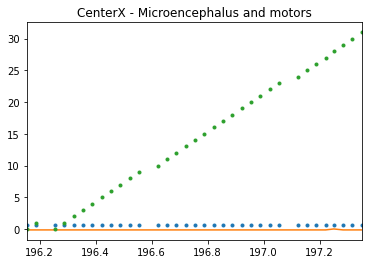

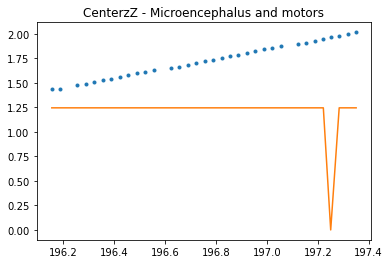

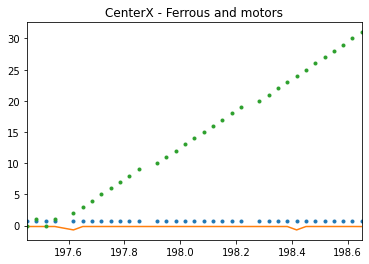

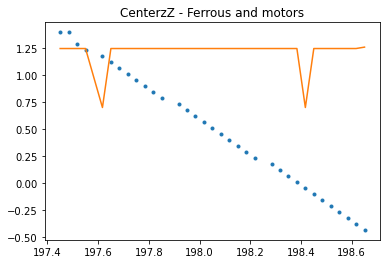

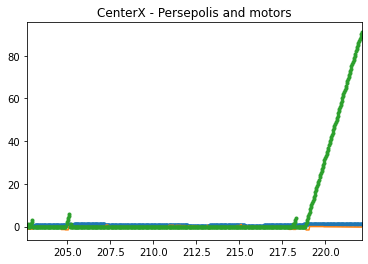

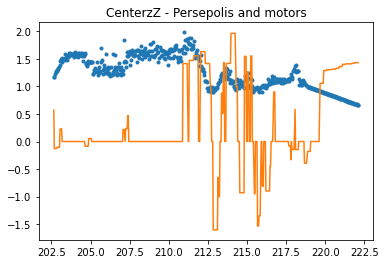

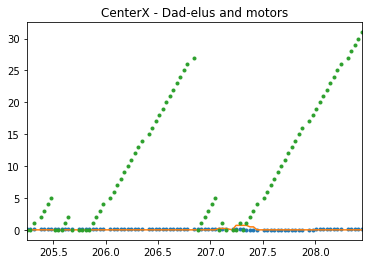

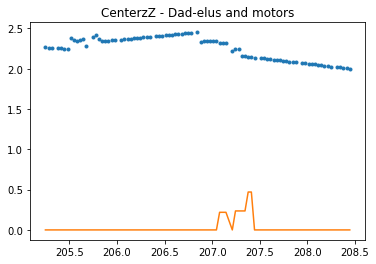

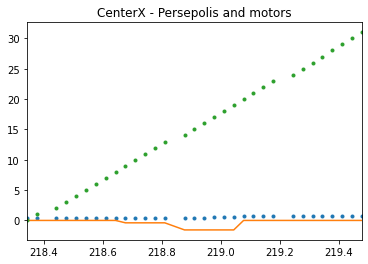

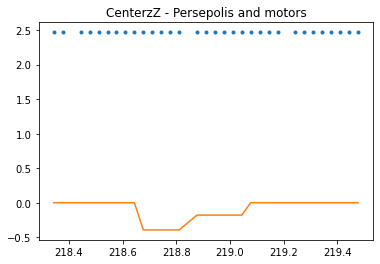

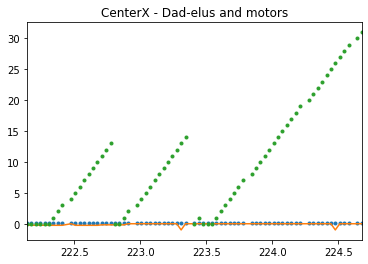

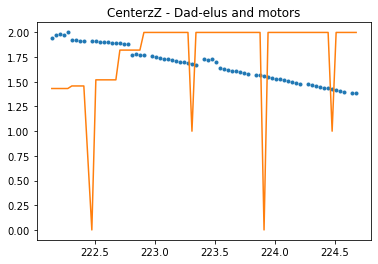

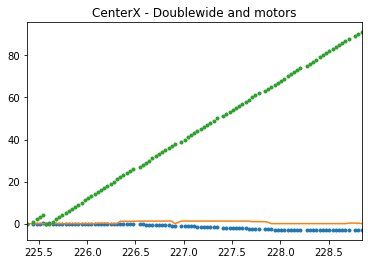

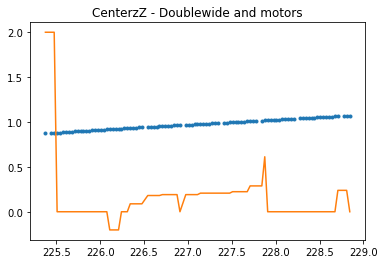

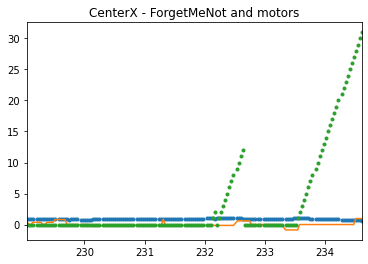

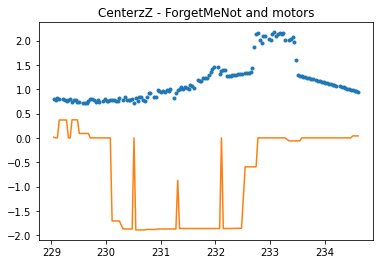

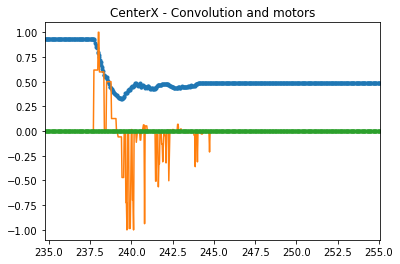

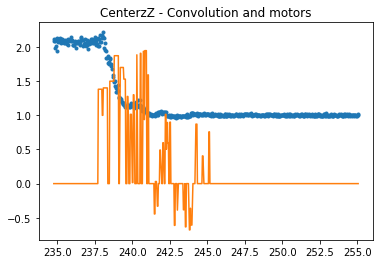

In [4]:
fig, ax = plt.subplots()
plt.title("Motors")
ax.plot(segmenter.motor_timestamp,segmenter.left_motor_on)
ax.plot(segmenter.motor_timestamp,segmenter.right_motor_on)
plt.show()

for key in segmenter.track_records:
    record=segmenter.track_records[key]
    if False:
        fig, ax = plt.subplots()
        plt.title("Center - {}".format(id_to_name(record.id)))
        ax.plot(record.timestamps,record.centers,'.')
        plt.show()
    if True:
        fig, ax = plt.subplots()
        plt.title("CenterX - {} and motors".format(id_to_name(record.id)))
        plt.xlim(record.timestamps[0],record.timestamps[-1])
        ax.plot(record.timestamps,record.centers[:,0],'.')
        ax.plot(record.timestamps,record.l_motor-record.r_motor)
        ax.plot(record.timestamps,record.missed_frames,'.')
        #ax.plot(segmenter.motor_timestamp+time_ref,segmenter.left_motor_on-segmenter.right_motor_on)
        plt.show()
        fig, ax = plt.subplots()
        plt.title("CenterzZ - {} and motors".format(id_to_name(record.id)))
        #plt.xlim(record.timestamps[2],record.timestamps[-1])
        ax.plot(record.timestamps,record.centers[:,2],'.')
        ax.plot(record.timestamps,record.l_motor+record.r_motor)
        #ax.plot(segmenter.motor_timestamp+time_ref,segmenter.left_motor_on-segmenter.right_motor_on)
        plt.show()

#plt.title("zvel")
#plt.xlim([65,70])
#zgyro_t=[]
#zgyro_v=[]
#for g in motioncorrection.gyros:
#    zgyro_t.append(g[0])
#    zgyro_v.append(g[1])
    
#fig, ax = plt.subplots()
#ax.plot(zgyro_t,zgyro_v,'.')
#plt.show()

In [5]:
dx=[]
dz=[]
m=[]
ms=[]

for key in segmenter.track_records:
    record=segmenter.track_records[key]
    #based on what the motor does now, what does the center x do in 10 frames
    #motor_indices=np.searchsorted(record.timestamps,segmenter.motor_timestamp+time_ref)
    for i in range(len(record.timestamps)-10):
        x1=record.centers[i][0]
        x2=record.centers[i+10][0]
        z1=record.centers[i][2]
        z2=record.centers[i+10][2]
        #motor=(segmenter.left_motor_on-segmenter.right_motor_on)[motor_indices[i]]
        motor=record.l_motor[i]-record.r_motor[i]
        if abs(x1)<1 and abs(x2)<1:
            m.append(motor)
            ms.append(record.l_motor[i]+record.r_motor[i])
            dx.append(x2-x1)
            dz.append(z2-z1)
print(len(dx))
        

4029


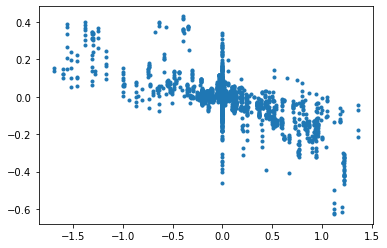

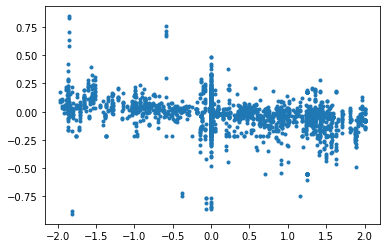

In [6]:
fig, ax = plt.subplots()
plt.plot(m,dx,'.')
plt.show()
fig, ax = plt.subplots()
plt.plot(ms,dz,'.')
plt.show()

In [7]:
import torch
from torch.utils.data import Dataset,ConcatDataset

class TrackDataset(Dataset):
    def __init__(self,input_vectors,control_vectors,output_vectors,prefix_length,prediction_length):
        self.input_vectors=torch.tensor(input_vectors).float()
        self.control_vectors=torch.tensor(control_vectors).float()
        self.output_vectors=torch.tensor(output_vectors).float()
        self.prefix_length=prefix_length
        self.prediction_length=prediction_length
    
    def __len__(self):        
        return max(len(self.input_vectors)-self.prefix_length-self.prediction_length+1,0)
        
    def __getitem__(self,index):
        return self.input_vectors[index:index+self.prefix_length],self.control_vectors[index:index+self.prefix_length],self.control_vectors[index+self.prefix_length:index+self.prefix_length+self.prediction_length],self.output_vectors[index+self.prefix_length:index+self.prefix_length+self.prediction_length,:]  
        
prefix_length=15
prediction_length=10
dataset_list=[]
for key in segmenter.track_records:
    i,c,o=segmenter.track_records[key].generate_training_data()
    td=TrackDataset(i,c,o,prefix_length,prediction_length)
    print("len td {}".format(len(td)))
    dataset_list.append(td)
full_dataset=ConcatDataset(dataset_list)
print("full lengt h{}".format(len(full_dataset)))

len td 1190
len td 301
len td 0
len td 383
len td 154
len td 228
len td 0
len td 0
len td 431
len td 4
len td 0
len td 0
len td 0
len td 75
len td 530
full lengt h3296


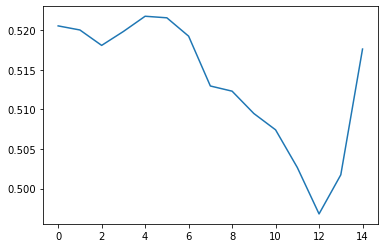

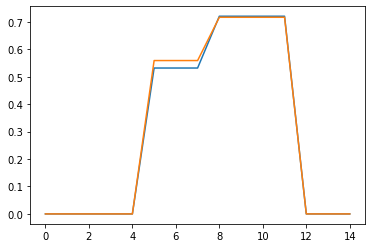

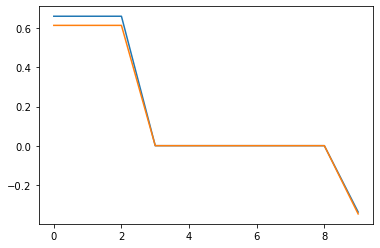

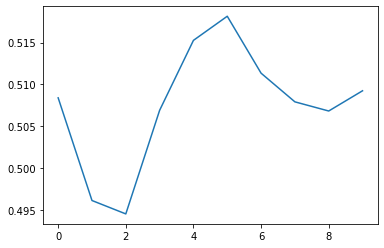

In [8]:
fig, ax = plt.subplots()
ax.plot(full_dataset[4][0])
plt.show()
fig, ax = plt.subplots()
ax.plot(full_dataset[4][1])
plt.show()
fig, ax = plt.subplots()
ax.plot(full_dataset[4][2])
plt.show()
fig, ax = plt.subplots()
ax.plot(full_dataset[4][3])
plt.show()

In [9]:
import torch.nn as nn

class Model(nn.Module):
    def __init__(self,input_size,control_size,output_size):
        super().__init__()
        hidden_size=input_size+control_size
        self.encoder_lstm=nn.LSTM(input_size+control_size,
                               hidden_size=hidden_size,
                               num_layers=1,
                               batch_first=True)
        self.decoder_lstm=nn.LSTM(control_size,
                               hidden_size=hidden_size,
                               num_layers=1,
                               batch_first=True)
        self.decoder_interpreter=nn.Sequential(nn.Linear(hidden_size,output_size),
                                               nn.Sigmoid())

    def predict_from_hc(self,hc,output_control_vectors):
        encoded_outputs,output_hc=self.decoder_lstm(output_control_vectors,hc)
        results=self.decoder_interpreter(encoded_outputs)
        return results,output_hc
        
    def forward(self,input_vectors,input_control_vectors,output_control_vectors):
        #print("input shape {}".format(input_vectors.shape))
        #print("input control shape {}".format(input_control_vectors.shape))
        #print("output control shape {}".format(output_control_vectors.shape))        
        #encode
        total_input_vectors=torch.cat((input_vectors,input_control_vectors),2)
        encoded_inputs,(hencoding,cencoding)=self.encoder_lstm(total_input_vectors)
        #print("hencoding shape {}".format(hencoding.shape))
        #decode
        #encoded_outputs,output_hc=self.decoder_lstm(output_control_vectors,(hencoding,cencoding))        
        #results=self.decoder_interpreter(encoded_outputs)
        #return results,output_hc
        return self.predict_from_hc((hencoding,cencoding),output_control_vectors)
        
        


In [10]:
from torch.utils.data import Dataset,DataLoader,TensorDataset,random_split
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm


mymodel=Model(1,2,1)

def train(mymodel,dataset):
    loader=DataLoader(dataset,batch_size=64,shuffle=True)
    loss_function = torch.nn.MSELoss()
    optimizer = optim.Adam(mymodel.parameters(), lr=0.01)
    train_epochs=100
    losses=[]
    for epoch in tqdm(range(train_epochs)):
        for inputs,control_inputs,control_outputs,outputs in loader:
            yprime,_=mymodel(inputs,control_inputs,control_outputs)         
            loss=loss_function(yprime,outputs )
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
    return losses

the_losses=train(mymodel,full_dataset)







100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.33it/s]


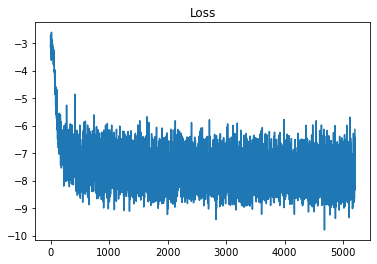

In [11]:
fig, ax = plt.subplots()
plt.title("Loss")
ax.plot(np.log(the_losses))
plt.show()

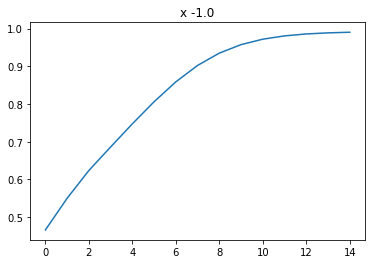

torch.Size([1, 15, 1])


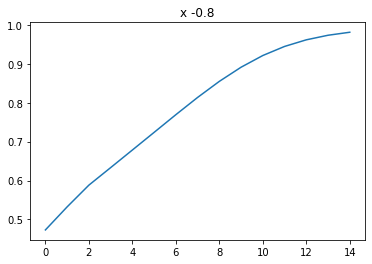

torch.Size([1, 15, 1])


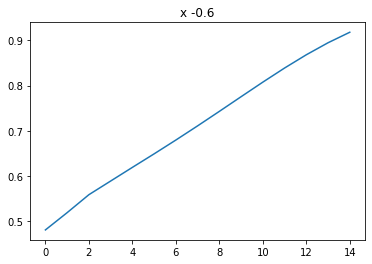

torch.Size([1, 15, 1])


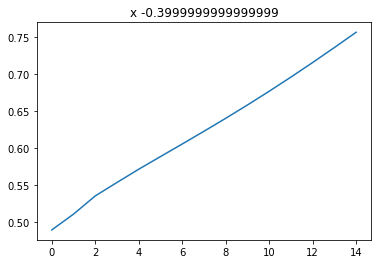

torch.Size([1, 15, 1])


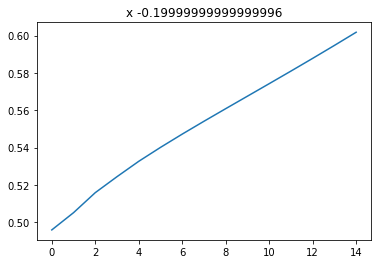

torch.Size([1, 15, 1])


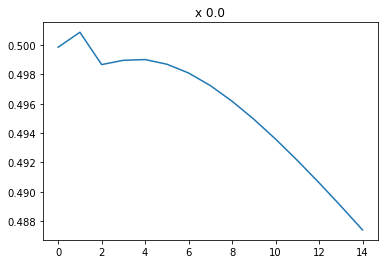

torch.Size([1, 15, 1])


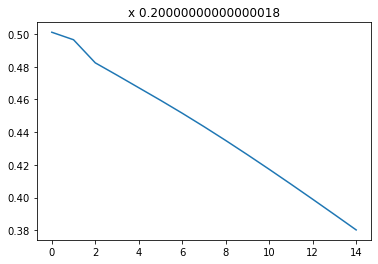

torch.Size([1, 15, 1])


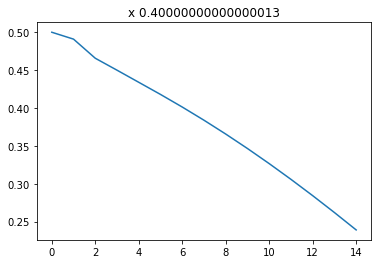

torch.Size([1, 15, 1])


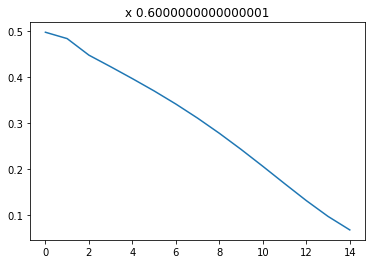

torch.Size([1, 15, 1])


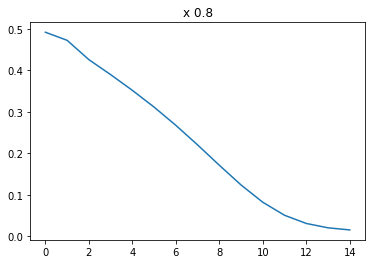

torch.Size([1, 15, 1])


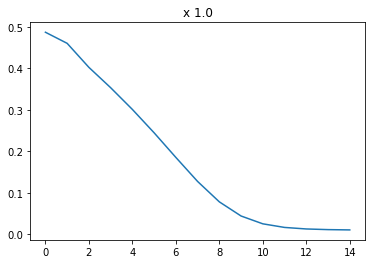

torch.Size([1, 15, 1])


In [12]:
test_input=torch.unsqueeze(torch.unsqueeze((0.5*torch.ones(15)),1),0)
test_input_control=torch.unsqueeze(torch.zeros([15,2]),0)

for x in np.linspace(-1,1,11):
    left=torch.ones([15,1])
    right=-torch.ones([15,1])
    combo=x*torch.unsqueeze(torch.cat([left,right],1),0)
    output,_=mymodel(test_input,test_input_control,combo)
    
    fig, ax = plt.subplots()
    plt.title("x {}".format(x))
    plt.plot(output.detach().numpy()[0,:,0])
    plt.show()

    print(output.shape)

#print(test_input.shape)
#print(test_control.shape)

In [13]:
import random
class Policy(nn.Module):
    def __init__(self):
        super().__init__()
        #self.network=nn.Sequential(nn.Linear(1,2),nn.Tanh())
        self.network=nn.Sequential(nn.Linear(1,2),nn.Tanh(),nn.Linear(2,2),nn.Tanh())

        
    def forward(self,x,target_x):
    #given the last X, declare the next action step        
    #def dothang(self,last_x,target_x):
        return self.network(x-target_x*torch.ones(x.shape))
        
def train_policy(policy,model,dataset):
    n_steps_to_test=10
    loss_function = torch.nn.MSELoss()
    total_loss=torch.zeros(1)

    #using a bunch of realistic starting points
    loader=DataLoader(dataset,batch_size=64,shuffle=True)
    optimizer = optim.Adam(policy.parameters(), lr=0.01)
    losses=[]
    n_epochs=50

    for epoch in tqdm(range(n_epochs)):
        #predict up to where I can make a decision
        for inputs,control_inputs,control_outputs,outputs in loader:
            #pick a random target
            target=random.uniform(0.1,0.9)
            target_yprime=target*torch.ones(outputs.shape)
            #target_yprime=target_yprime[:,-1:,:]
            #I presume I am 4 frames ahead in control inputs
            control_ahead=control_outputs[:,0:4,:]
            yprime,hc=mymodel(inputs,control_inputs,control_ahead)
            next_yprime=yprime[:,-1:,:]
            #print("yprime shape {}".format(next_yprime.shape))
            next_yprimes=[]

            for i in range(n_steps_to_test):
                next_steps=policy(next_yprime,target)
                next_yprime,hc=model.predict_from_hc(hc,next_steps)
                next_yprimes.append(next_yprime)                
                #print("yprime shape {}".format(next_yprime.shape))
                #print("target yprime shape {}".format(target_yprime.shape))
                #this_loss=loss_function(next_yprime,target_yprime)
                #print("this loss shape {}".format(this_loss.shape))
                #total_loss+=this_loss
            all_yprimes=torch.cat(next_yprimes,1)
            #print("all yprimes {}".format(all_yprimes.shape))
            loss=loss_function(all_yprimes,target_yprime)
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
    return losses
        
mypolicy=Policy()

losses=train_policy(mypolicy,mymodel,full_dataset)



        

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.87it/s]


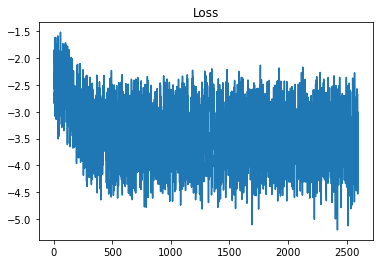

In [14]:
fig, ax = plt.subplots()
plt.title("Loss")
ax.plot(np.log(losses))
plt.show()

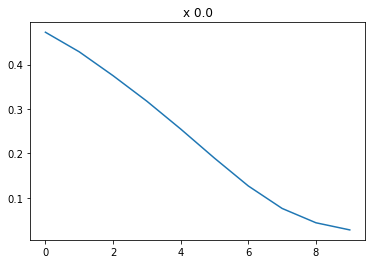

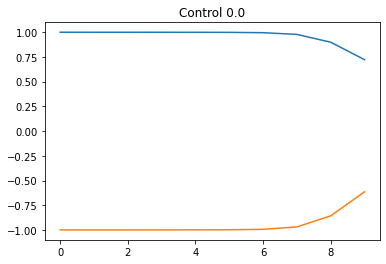

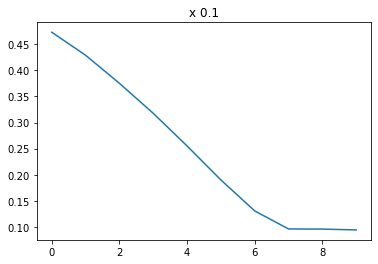

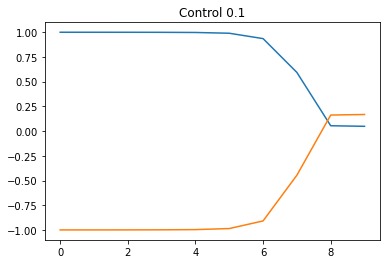

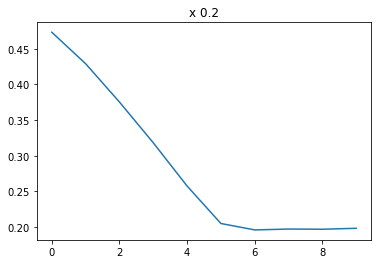

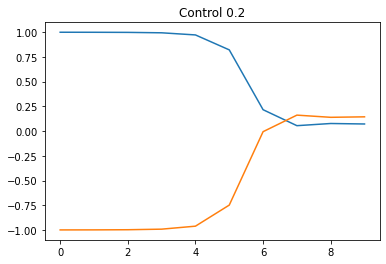

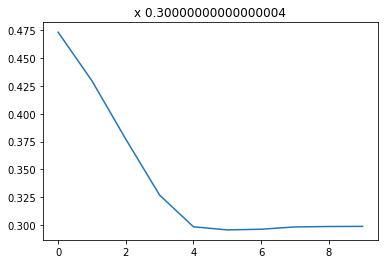

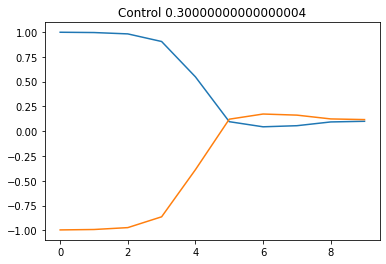

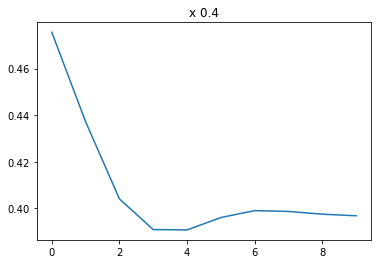

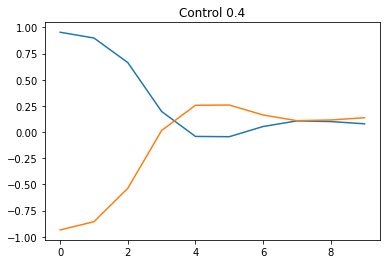

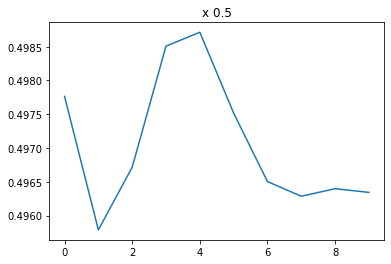

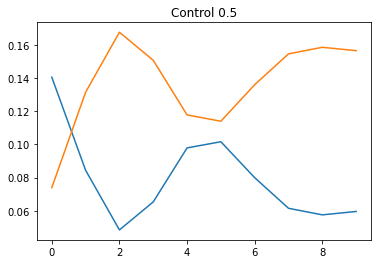

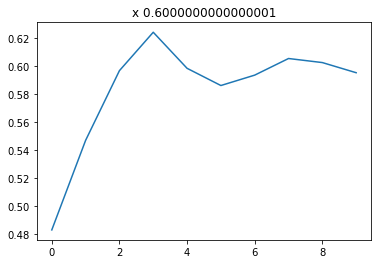

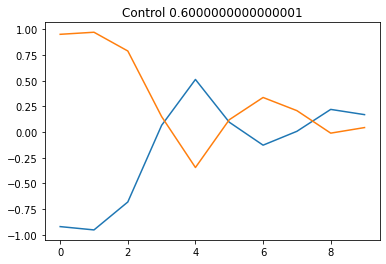

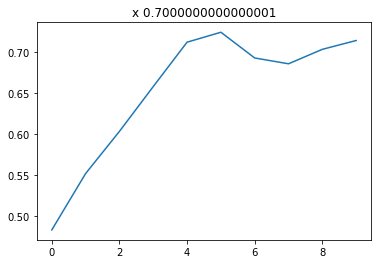

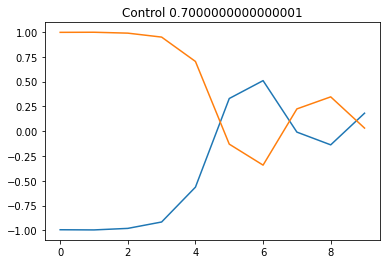

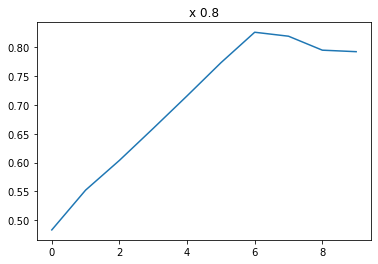

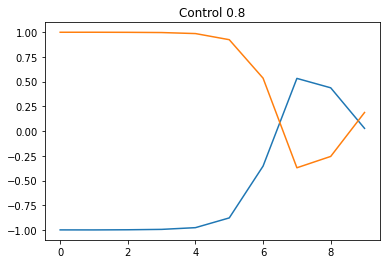

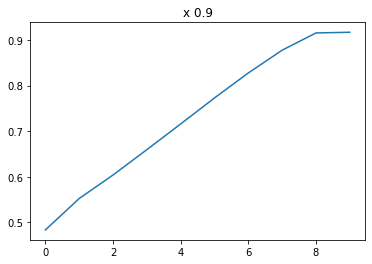

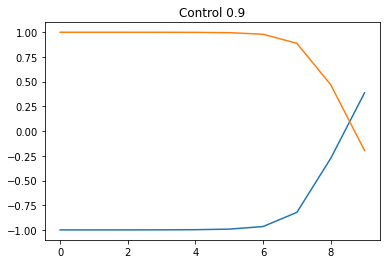

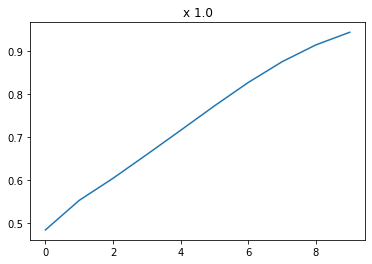

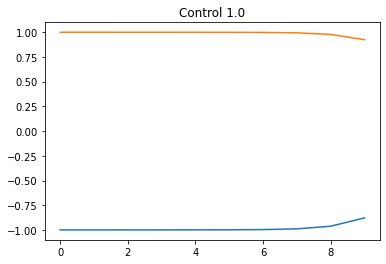

In [15]:
test_input=torch.unsqueeze(torch.unsqueeze((0.5*torch.ones(15)),1),0)
test_input_control=torch.unsqueeze(torch.zeros([15,2]),0)
control_ahead=torch.unsqueeze(torch.zeros([2,2]),0)

model=mymodel
policy=mypolicy
n_steps_to_test=10
for x in np.linspace(0,1,11):
    yprime,hc=mymodel(test_input,test_input_control,control_ahead)
    next_yprime=yprime[:,-1:,:] 
    next_yprimes=[]
    next_steps_array=[]
    for i in range(n_steps_to_test):
        next_steps=policy(next_yprime,x)
        next_steps_array.append(next_steps)
        next_yprime,hc=model.predict_from_hc(hc,next_steps)
        next_yprimes.append(next_yprime)           
    all_yprimes=torch.cat(next_yprimes,1).detach().numpy()
    all_nextsteps=torch.cat(next_steps_array,1).detach().numpy()
    fig, ax = plt.subplots()
    plt.title("x {}".format(x))
    plt.plot(all_yprimes[0,:,0])    
    plt.show()
    fig, ax = plt.subplots()
    plt.title("Control {}".format(x))
    plt.plot(all_nextsteps[0,:,:])    
    plt.show()

#    left=torch.ones([15,1])
#    right=-torch.ones([15,1])
#    combo=x*torch.unsqueeze(torch.cat([left,right],1),0)
#    output,_=mymodel(test_input,test_input_control,combo)
    
#    fig, ax = plt.subplots()
#    plt.title("x {}".format(x))
#    plt.plot(output.detach().numpy()[0,:,0])
#    plt.show()

#    print(output.shape)